In [1]:
!pip install cloudscraper
!pip install html5lib

In [2]:
import pandas as pd
import numpy as np
import requests
import cloudscraper
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt 
import re
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import plotly.express as px
from ipywidgets import interact, widgets
from IPython.display import display
pd.option_context('mode.use_inf_as_na', True)

 ### Library Installation 
To enable scraping of websites with anti-bot mechanisms, the `cloudscraper` library is installed. This library is particularly useful for bypassing Cloudflare protection and retrieving webpage content. The result is a successfull. The retrieved HTML content is parsed using the BeautifulSoup library.

In [3]:
def scraping(url):
    scraper = cloudscraper.create_scraper()
    data = scraper.get(url).text
    soup=BeautifulSoup(data, "html.parser")
    divs= soup.find_all('div', class_='items-i')
    return divs

### Extracting data

This function processes the HTML content retrieved by the scraping function to extract detailed information about real estate listings. Key steps include:

- Extracting attributes like price, currency, location, number of rooms, floor number, and apartment area using specific HTML tags and classes.
- Parsing repair level and document status conditionally based on the presence of relevant HTML elements.
- Extracting and converting date information from image URLs.
- Organizing the extracted information into a structured pandas DataFrame.
  
The result is a well-structured dataset containing all the relevant information from the webpage for further analysis.



In [4]:
def extract_data(divs):
    all_data = []
    for div in divs:
        price=div.select_one(".price-val").text
        currency=div.select_one(".price-cur").text
        location=div.select_one(".location").text
    
        list_items = div.find_all('li')
        number_of_rooms = list_items[0].get_text(strip=True)
        area_of_apartment = list_items[1].get_text(strip=True)
        floor_number = list_items[2].get_text(strip=True)


        repair_div = div.find('div', class_='repair')
        if repair_div:
            repair_level = repair_div.find('span').get_text(strip=True)
        else:
            repair_level = 'Təmirsiz'


        bill_of_sale_div = div.find('div', class_='bill_of_sale')
        if bill_of_sale_div:
            offical_document_status = bill_of_sale_div.find('span').get_text(strip=True)
        else:
            offical_document_status = 'Müqavilə'
        
    

        img_items = div.find_all('img',  attrs={'class':'lazyload'})

    
        for image in img_items:
            
            decoded_url=image['data-src'].replace('%2F', '/')
            parts = decoded_url.split('/')
            date_string = ''.join(parts[5:8])
            date = pd.to_datetime(date_string, format='%Y%m%d')
            
        
        all_data.append(
             {

                "Location": location,
                "Number of rooms": number_of_rooms,
                "Floor number": floor_number,
                "Area of apartment": area_of_apartment,
                "Price": price,
                "Currency": currency,
                "Date": date,
                "Condition": repair_level,
                "Document status":offical_document_status
            
             }
         )
    

    
    df = pd.DataFrame(all_data)
    return df

### Obtaining data frame
This code dynamically scrapes multiple pages of real estate listings by constructing URLs with a page number placeholder (%s). For each page, the scraping function fetches HTML content, and extract_data extracts relevant information into a DataFrame. All extracted DataFrames are appended to a list, which is then merged into a single DataFrame using pd.concat for efficient combination and reset indexing. Finally, duplicates are removed from the combined dataset with drop_duplicates(), resulting in a clean, unified DataFrame of all listings.

In [5]:
base_url='https://bina.az/baki/alqi-satqi/menziller/yeni-tikili?page=%s&sorting=bumped_at+desc'
all_df=[]
for page in range(1, 1384):
    url =base_url % page 
    scraped_data = scraping(url)
    extracted_data= extract_data(scraped_data)
    all_df.append(extracted_data)
    final_df = pd.concat(all_df, ignore_index=True)
    final_df.drop_duplicates()

In [6]:
#final_df['Area of apartment'].isna()
final_df


,Location,Number of rooms,Floor number,Area of apartment,Price,Currency,Date,Condition,Document status
0,Nardaran q.,3 otaqlı,3/4 mərtəbə,110 m²,375 000,AZN,2024-02-18,Təmirsiz,Çıxarış var
1,Həzi Aslanov m.,2 otaqlı,2/19 mərtəbə,85 m²,198 000,AZN,2024-11-19,Təmirli,Çıxarış var
2,Nardaran q.,2 otaqlı,4/7 mərtəbə,93.7 m²,446 012,AZN,2024-07-04,Təmirli,Müqavilə
3,İçəri Şəhər m.,8 otaqlı,11/14 mərtəbə,584 m²,1 985 000,AZN,2024-10-24,Təmirsiz,Çıxarış var
4,Nəsimi r.,4 otaqlı,4/20 mərtəbə,191 m²,440 000,AZN,2024-11-04,Təmirsiz,Müqavilə
...,...,...,...,...,...,...,...,...,...
25167,Nardaran q.,2 otaqlı,2/7 mərtəbə,60 m²,223 000,AZN,2024-08-26,Təmirsiz,Müqavilə
25168,20 Yanvar m.,3 otaqlı,16/18 mərtəbə,135 m²,270 000,AZN,2024-09-25,Təmirli,Çıxarış var
25169,20 Yanvar m.,3 otaqlı,7/16 mərtəbə,110 m²,258 000,AZN,2024-10-17,Təmirli,Çıxarış var
25170,Yasamal r.,3 otaqlı,21/22 mərtəbə,103 m²,144 900,AZN,2024-10-04,Təmirli,Çıxarış var


Dataframe is saved as a csv file.


In [7]:
final_df.to_csv('bina_az.csv')

### Data cleaning

Parsing and Extracting Relevant Information:

- Using custom functions to extract specific values (e.g., numeric values or text units) from raw data fields.
- Removing unnecessary parts of text (like "m²" or extra characters) to keep only meaningful information.
  
### Data Transformation:

- Converting data into appropriate types (e.g., converting strings to integers or floats for numerical analysis).
- Structuring data into a clean, consistent format, like separating units and values into different columns.

  
Column Reorganization:

- Arranging columns in a logical order to improve readability and usability.


In [8]:

def extract_unit(data):
    unit=re.findall(r"[a-zA-Z²³]+", data)
    return unit[0]

def extract_value(data):
    value= re.findall(r"[-+]?\d*\.\d+|\d+", data)
    return float(value[0])

def extract_floor_number(data):
    floor_number = re.findall(r"\b\d+/\d+\b", data)
    return floor_number[0] 


final_df['Unit']= final_df['Area of apartment'].apply(extract_unit)
final_df['Area']= final_df['Area of apartment'].apply(extract_value)
final_df['Floor']= final_df['Floor number'].apply(extract_floor_number)
final_df['Room number']=final_df['Number of rooms'].apply(extract_value).astype(int)
final_df=final_df[['Location', 'Room number', 'Floor', 'Area', 'Unit', 'Price', 'Currency','Date','Condition','Document status' ,'Area of apartment', 'Number of rooms']]


In [9]:
final_df.head(20)

,Location,Room number,Floor,Area,Unit,Price,Currency,Date,Condition,Document status,Area of apartment,Number of rooms
0,Nardaran q.,3,3/4,110.0,m²,375 000,AZN,2024-02-18,Təmirsiz,Çıxarış var,110 m²,3 otaqlı
1,Həzi Aslanov m.,2,2/19,85.0,m²,198 000,AZN,2024-11-19,Təmirli,Çıxarış var,85 m²,2 otaqlı
2,Nardaran q.,2,4/7,93.7,m²,446 012,AZN,2024-07-04,Təmirli,Müqavilə,93.7 m²,2 otaqlı
3,İçəri Şəhər m.,8,11/14,584.0,m²,1 985 000,AZN,2024-10-24,Təmirsiz,Çıxarış var,584 m²,8 otaqlı
4,Nəsimi r.,4,4/20,191.0,m²,440 000,AZN,2024-11-04,Təmirsiz,Müqavilə,191 m²,4 otaqlı
5,Nizami m.,4,10/16,220.0,m²,679 800,AZN,2024-11-04,Təmirsiz,Müqavilə,220 m²,4 otaqlı
6,Hövsan q.,4,4/9,100.0,m²,118 000,AZN,2024-08-24,Təmirli,Çıxarış var,100 m²,4 otaqlı
7,Hövsan q.,2,4/7,52.0,m²,87 000,AZN,2024-11-23,Təmirli,Çıxarış var,52 m²,2 otaqlı
8,Nəsimi r.,2,6/12,75.0,m²,189 000,AZN,2024-06-04,Təmirsiz,Çıxarış var,75 m²,2 otaqlı
9,20 Yanvar m.,3,10/14,105.0,m²,256 500,AZN,2024-04-30,Təmirli,Müqavilə,105 m²,3 otaqlı


In [10]:
final_df['Price'] = final_df['Price'].str.replace(' ', '')
final_df = final_df.astype({'Price': 'int32'})
final_df['Price'].dtype



/var/folders/r4/vnj7ks7s4jqc9zgcn_j50_f80000gp/T/ipykernel_22493/4211635434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Price'] = final_df['Price'].str.replace(' ', '')


dtype('int32')

In [11]:
final_df.describe()

,Room number,Area,Price,Date
count,25172.000000,25172.000000,2.517200e+04,25172
mean,2.831837,115.130141,2.961753e+05,2024-09-19 18:12:48.854282496
min,1.000000,17.000000,2.800000e+04,2019-07-21 00:00:00
25%,2.000000,75.000000,1.750000e+05,2024-09-13 00:00:00
50%,3.000000,102.200000,2.480000e+05,2024-10-28 00:00:00
75%,3.000000,139.000000,3.500000e+05,2024-11-12 00:00:00
max,15.000000,1400.000000,5.100000e+06,2024-11-23 00:00:00
std,0.905472,63.340227,2.230540e+05,NaN


### Line plot for average price 

This section creates an interactive line plot to visualize the average property prices over time for a selected location and date range. A function, line_plot, filters the DataFrame based on the selected location and calculates the mean price grouped by date. The filtered data is plotted using plotly.express.line, with customizable x-axis formatting for better readability. Widgets, such as a dropdown menu for location selection and date pickers for start and end dates, allow users to interactively specify their preferences. The interact function dynamically updates the plot based on the selected inputs, making the visualization intuitive and user-friendly. This interactivity provides a powerful tool for exploring trends in the data.

In [12]:

#final_df['Date'] = pd.to_datetime(final_df['Date'])

def line_plot(location, start_date, end_date):
    
    # Filter the DataFrame for the selected location
    filtered_final_df = final_df[final_df['Location'] == location]
    # Group by date and calculate the mean price
    grouped_df = filtered_final_df.groupby('Date')['Price'].mean().reset_index()

    
    grouped_df = grouped_df[(grouped_df['Date'] >= pd.to_datetime(start_date)) & (grouped_df['Date'] <= pd.to_datetime(end_date))]

    
    fig=px.line(
        grouped_df,
        x='Date',
        y='Price',
        title=f'Average Price for {location}',
        height=1000, 
        width=1000
    )

    fig.update_xaxes(
    dtick="M3",
    tickformat="%b\n%Y"
    )

    fig.show()


location_dropdown= widgets.Dropdown(
    options=final_df['Location'].unique(),
    description='Location:',
    disabled=False
    
)

start_date_picker =widgets.DatePicker(
    description='Pick a start date',
    value=final_df['Date'].min(),
    disabled=False
)


end_date_picker =widgets.DatePicker(
    description='Pick an end date',
    value=final_df['Date'].max(),
    disabled=False
)



# Use the interact function to update the plot when a location is selected
interact(line_plot, location=location_dropdown, start_date=start_date_picker, end_date=end_date_picker)




interactive(children=(Dropdown(description='Location:', options=('Nardaran q.', 'Həzi Aslanov m.', 'İçəri Şəhə…

<function __main__.line_plot(location, start_date, end_date)>

### Number of apartments based on location

- This section creates a bar chart to visualize the number of apartments in different locations, categorized by their condition (renovated or unrenovated), along with their median price. First, the data is grouped by location and condition to count apartments and calculate their median prices. A pivot table is created to restructure the data for bar chart visualization, with additional columns for totals and condition-specific counts. The data is then sorted by total count for better readability. The bar chart is generated using plotly.express, with hover labels providing details such as location, count, and median price. The layout is customized to include labeled axes, angled x-axis labels, and text annotations on the bars, making the visualization clear and informative.


- The bar chart shows a skewed distribution of apartments, with locations like Nizami q. and Yasamal q. having the highest counts, indicating concentrated real estate activity in these areas. The sharp decline in counts for other locations highlights less populated regions. The color scale effectively differentiates high-demand areas, providing valuable insights for targeted real estate investments or marketing efforts.

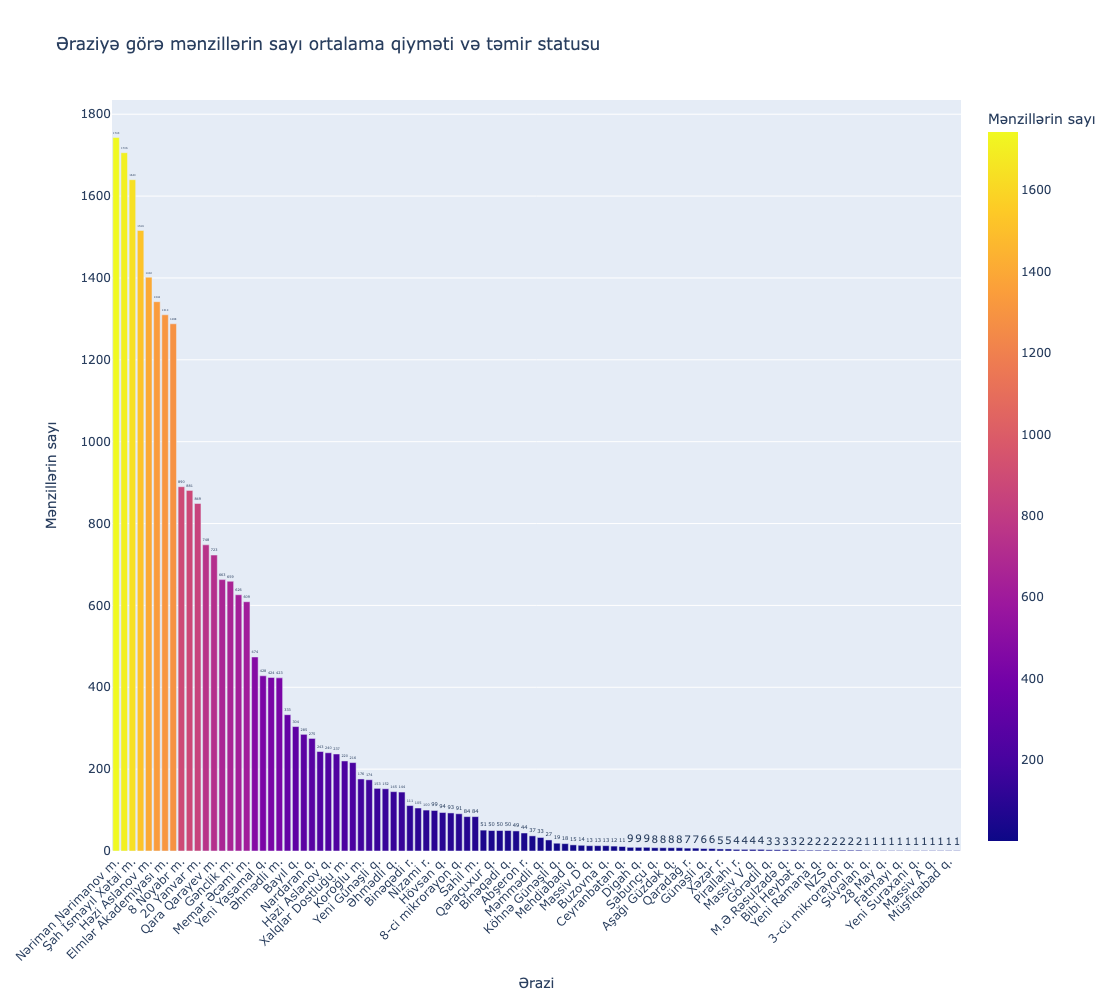

In [13]:
#Bar graph to show number of apartments and their condition status when hover 

new_df=final_df.groupby('Location',as_index=False)['Condition'].value_counts()

average_df=final_df.groupby('Location', as_index=False)['Price'].median()

# Pivot the DataFrame to get counts for each condition
pivot_df = new_df.pivot_table(
    index='Location',    
    columns='Condition',
    values='count',
    fill_value=0
)

# Rename columns for clarity                 
pivot_df.columns = ['Təmirli', 'Təmirsiz']   

# Add a Total column
pivot_df['Total'] = pivot_df['Təmirli'] + pivot_df['Təmirsiz'] 

merged_df = pd.merge(average_df, pivot_df, on='Location')


merged_df[['Təmirli','Təmirsiz','Total']]= merged_df[['Təmirli','Təmirsiz','Total']].astype(int)
                                                                 
# Reset index to turn the location into a column again              
merged_df.reset_index(inplace=True)

# Sort DataFrame by 'Total' in ascending order
pivot_sorted_df = merged_df.sort_values(by='Total',ascending=False)


fig = px.bar(
    pivot_sorted_df, 
    x='Location', 
    y='Total', 
    text='Total',  # Add text labels to bars
    title='Əraziyə görə mənzillərin sayı ortalama qiyməti və təmir statusu',
    labels={'Location': 'Ərazi','Total': 'Mənzillərin sayı','Price':'Ortalama qiymət'},  # Axis label customization
    color='Total', 
    hover_data={
        'Location': True,  # Display location on hover
        'Təmirli': True,   # Display Təmirli count on hover
        'Price': True,  # Display Təmirsiz count on hover
        'Total': True       # Display Total count on hover
    }
)

# Customize the layout
fig.update_layout(
    xaxis_title='Ərazi',
    yaxis_title='Mənzillərin sayı',
    xaxis_tickangle=-45,  # Tilt the x-axis labels if they are long
    width=1000,
    height=1000
)

# Add text labels on bars
fig.update_traces(texttemplate='%{text}', textposition='outside')



This code generates an interactive scatter plot to visualize the relationship between apartment price and area for a selected location. The points are color-coded by condition (e.g., renovated or unrenovated), with hover labels displaying additional details like document status. The trendline feature is included to highlight the overall trend. A dropdown widget allows users to select a specific location, dynamically updating the plot for exploratory analysis.

In [14]:
#Scatter plot Price versus Area based on location



def scatter_plot(location):
    
    filtered_df_scatter_plot = final_df[final_df['Location'] == location]
    fig = px.scatter(
        filtered_df_scatter_plot,
        x='Area', 
        y='Price',
        color='Condition',
        labels={'Area':'Mənzilin sahəsi (mˆ2)', 'Price':'Mənzilin qiymeti (AZN)', 'Condition':'Təmir statusu', 'Document status':'Mənzilin sənədi'},
        hover_data=['Price','Area', 'Condition', 'Document status'],
        #symbol="Document status",
        #size= 20,
        title='Əraziyə əsasən mənzilin sahəsi ilə qiyməti arasındakı əlaqə',
        width=1000,
        height=600,
        trendline="ols"
        #trendline_scope="overall"
    )
    
    fig.show()


location_dropdown = widgets.Dropdown(
    options=final_df['Location'].unique(),
    description='Location:',
    disabled=False
)


interact(scatter_plot, location=location_dropdown)



interactive(children=(Dropdown(description='Location:', options=('Nardaran q.', 'Həzi Aslanov m.', 'İçəri Şəhə…

<function __main__.scatter_plot(location)>

This code generates an interactive box plot to compare apartment prices based on the number of rooms for a selected location. The plot is color-coded by document status, providing additional insights into property legality or ownership. Hover labels display detailed information such as price, room number, and document status. A dropdown widget allows users to select a specific location, dynamically updating the box plot to explore variations in price distribution across room categories.

In [15]:

def box_plot(location):
    filtered_df_box_plot = final_df[final_df['Location'] == location]
    
    fig = px.box(filtered_df_box_plot,
                 
                 x="Room number", 
                 y="Price", 
                 points="all", 
                 width=1000,
                 height=1000,
                 title='Seçilmiş ərazidə otaq sayı ilə qiymət qarşılaşdırması',
                 color='Document status',
                 labels={'Room number': 'Otaq sayı','Price':'Qiymət', 'Document status':'Sənəd növü'}

                )
    fig.show()

Locations=widgets.Dropdown(
    options=final_df['Location'].unique(),
    description='Location:',
    disabled=False
)

interact(box_plot, location=location_dropdown)



interactive(children=(Dropdown(description='Location:', index=7, options=('Nardaran q.', 'Həzi Aslanov m.', 'İ…

<function __main__.box_plot(location)>